In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import scipy.io
import os
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import functions
from metpy.units import units
import metpy.calc as mpcalc

def wrap_ds(input_ds, var_name, var_attrs):
    """
    Wrap xarray datasets with attributes.

    Parameters:
    - input_ds (xr.Dataset): The input xarray dataset.
    - var_name (str): The name of the new variable to be added.
    - var_attrs (dict): Attributes to be added to the new variable.
      e,g. new_variable_attrs = {'description': 'New variable data', 'units': 'meters'}
    """
    # Create a new dataset and add the variable
    new_ds = xr.Dataset({f'{var_name}': input_ds.copy()})
    # Add attributes to the variable in the dataset 
    new_ds[f'{var_name}'].attrs.update(var_attrs)

    return new_ds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
model   = 'control'
expid   = 'r1i1'
forcing = 'hist'
path = f'/data1/jzhuo/cesm/data_shared/{model}/{expid}/Amon'

resolution = 2
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90+resolution, resolution)), 
                     'lon': (['lon'], np.arange(0, 360, resolution))})

In [12]:
path

'/data1/jzhuo/cesm/data_shared/control/r1i1/Amon'

In [8]:
# Landmask:
dslmsk = xr.open_dataset(f"{path}/LANDFRAC.hist.1950-2014.nc")['LANDFRAC'].isel(time=0)

## 1. Absolute vorticity

In [14]:
def f_absolute_vort(u_wind, v_wind):
    # calculate absolute vorticity [s-1]
    u_wind = u_wind * units('m/s')
    v_wind = v_wind * units('m/s')
    absolute_vort = mpcalc.absolute_vorticity(u_wind, v_wind, x_dim='lon',
                                              y_dim='lat')  # (x_dim:lon, y_dim:lat)
    absolute_vort_ds = wrap_ds(absolute_vort.metpy.dequantify(), 'avort', {'long_name': 'absolute vorticity'})
    return absolute_vort_ds

In [15]:
# Input data
u = xr.open_dataset(f"{path}/U.{forcing}.1950-2014.nc").sel(lev=850,method='nearest').U.sel(time=slice('2013','2014'))
v = xr.open_dataset(f"{path}/V.{forcing}.1950-2014.nc").sel(lev=850,method='nearest').V.sel(time=slice('2013','2014'))
# Calculate avort
avort = f_absolute_vort(u,v)#.rename({'latitude': 'lat', 'longitude':'lon'})

# Regrid resolution to 2*2 degree
#regridder = xe.Regridder(avort, ds_out, 'bilinear', periodic=True)
#avort_r = regridder(avort)

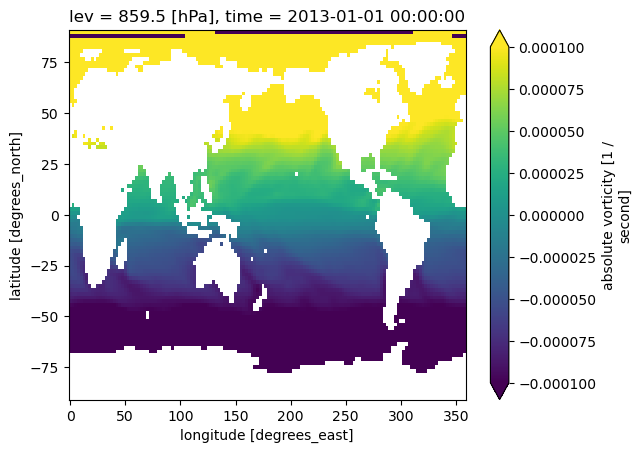

In [17]:
noland = (dslmsk)
avort.avort.where(noland.data==0).isel(time=0).plot(vmax=1e-04, vmin=-1e-04)
plt.savefig('avort.png')

## 2. Vertical wind shear

In [18]:
def f_vertical_wind_shear(ds_u, ds_v, upper_level=200, lower_level=850):
    delta_u = ds_u.sel(lev=upper_level,method='nearest') - ds_u.sel(lev=lower_level,method='nearest')
    delta_v = ds_v.sel(lev=upper_level,method='nearest') - ds_v.sel(lev=lower_level,method='nearest')
    # Calculate the magnitude of the wind shear
    vws = np.sqrt(delta_u**2 + delta_v**2)

    return wrap_ds(vws, 'vws', {'unit': 'm s-1','long_name': f'magnitude of the wind shear between {upper_level}- and {lower_level}-hPa'})

In [19]:
# Input data
u = xr.open_dataset(f"{path}/U.{forcing}.1950-2014.nc").U.sel(time=slice('2013','2014'))
v = xr.open_dataset(f"{path}/V.{forcing}.1950-2014.nc").V.sel(time=slice('2013','2014'))
# Calculate wind shear
vws = f_vertical_wind_shear(u,v)

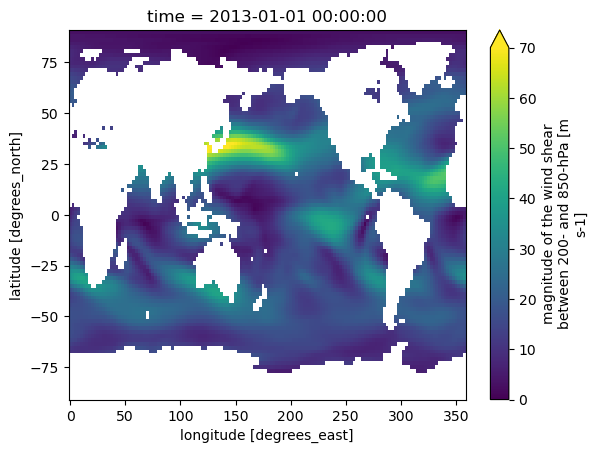

In [21]:
#noland = (dslmsk.LANDFRAC)
vws.vws.isel(time=0).where(noland.data==0).plot(vmin=0, vmax=70)
plt.savefig('vws.png')

## 3. Column relatvie humidity (CRH) and saturation deﬁcit (SD)

In [22]:
def saturation_vapor_pressure(ta):
    '''
    Calculate saturation water vapor pressure (es) based on formula given in Bolton (1980). If T is replaced by the dew point Td, this function will return the water vapor pressure (e).

    Parameters:
    - T: temperature at multi-layers [C]
    - es: saturation water vapor pressure [hPa]
    '''
    if ta.sortby(level_dim, ascending=False)[0, -1, 0, 0] > 100:
        ta = ta - 273.3  # change unit to Calcius if nessesary
    es = 6.112 * np.exp(17.67 * ta / (ta + 243.5))
    es_ds = wrap_ds(es, 'es', {'unit': 'hPa', 'long_name': 'saturation vapor pressure'})
    return es_ds


def saturation_specific_humidity(ta, level_dim='lev'):
    '''
    Calculate saturation specific humidity (qs) based on formula given in Bolton (1980). If T is replaced by the dew point Td, this function will return the specific humidity (q).

    Parameters:
    - T: temperature at multi-layers [C]
    - p: pressure at multi-layers [Pa]
    - es: saturation water vapor pressure [Pa]
    - qs: saturation specific humidity [g kg-1]
    '''
    if ta.sortby(level_dim, ascending=False)[0, -1, 0, 0] > 100:
        ta = ta - 273.3  # change unit to Calcius if nessesary

    es, qs = [np.zeros_like(ta) for _ in range(2)]
    eps = 0.62197
    for i in range(len(ta[level_dim])):
        p = ta[level_dim][i].data
        T = ta[:, i]
        es[:, i] = 611.2 * np.exp(17.67 * T / (T + 243.5))
        qs[:, i] = (eps * es[:, i]) / (p - (1 - eps) * es[:, i])
    qs_ds = wrap_ds(xr.DataArray(qs, dims=ta.dims, coords=ta.coords), 'qs',
                    {'unit': 'kg kg-1', 'long_name': 'saturation specific humidity'})
    return qs_ds


def f_saturated_water_vapor(ta, psl, ts, level_dim='lev'):
    '''
    Calculate saturated water vapor (swv [kg m-2]) 

    Input datasets:
    - ta: temperature at multi-layers [C/K]
    - psl: mean sea level pressure [Pa/hPa]
    - ts: skin temperature (SST) [C/K]
    '''
    ta = ta.sortby(level_dim, ascending=True)
    psl = psl
    ts = ts

    # adjust units
    if ta.sortby(level_dim, ascending=True)[level_dim][-1].item() < 9000:
        ta = ta.assign_coords(**{level_dim: ta[level_dim].data * 100})  # change unit to Pa if nessesary
    if psl[0, 0, 0] < 9000:
        psl = psl * 100  # change unit to Pa if nessesary
    if ts[0, 0, 0] > 100:
        ts = ts - 273.3  # change unit to Calcius if nessesary

    # Setting constants
    pubc = 15000 # Upper BC pressure at which we take qs = 0.
    pmin = 10000
    pmax = 100000  # Min & Max pressure level at which qs is computed [Pa]
    g = 9.81
    eps = 0.62197

    # Calculate saturation specific humidity
    qs = saturation_specific_humidity(ta, level_dim)
    qs = qs.qs.sel({f'{level_dim}': slice(pmin, pmax)})
    
    qsold, swv = [np.zeros_like(psl) for _ in range(2)]
    for ilevel in range(len(qs[level_dim].sel({f'{level_dim}': slice(pubc, pmax)})) - 1):
        ilevel_bc = np.argmin(abs(qs[level_dim].values-pubc))
        ilevel = ilevel + ilevel_bc
        if ilevel == ilevel_bc:
            '''
            Add wvp contribution from layer lev-0.5, 
            where we take qs=0 (can't use log approx)
            '''
            dpres = qs[level_dim].isel({f'{level_dim}': ilevel}).values - qs[level_dim].isel(
                {f'{level_dim}': (ilevel - 1)}).values
            swv = 0.5 * qs.sel({f'{level_dim}': pubc}, method='nearest') * dpres / g
        else:
            '''
            If we assume log(qs) is a linear function of p
            wvp contribution is qs*(dp/g)*f(x), f(x) = -x/log(1-x) 
            Use a Taylor series approx to f(x) to avoid roundoff
            problems near x = 0. The standard trapezoidal rule is equivalent
            to only keeping the linear term in the Taylor series. This
            typically leads to overestimates of 0.5-1.5 mm in swv.
            '''
            x = 1 - (qsold / qs.isel({f'{level_dim}': ilevel}))
            tay = 1 - (x / 2) - (x ** 2 / 12) - (x ** 3 / 24)
            dpres = qs[level_dim].isel({f'{level_dim}': ilevel}).values - qs[level_dim].isel(
                {f'{level_dim}': (ilevel - 1)}).values
            vv = qs.isel({f'{level_dim}': ilevel}) * tay * dpres / g
            vvz = np.nan_to_num(vv)  # Replace NaN values with 0 in vv
            swv = swv + vvz
        qsold = qs.isel({f'{level_dim}': ilevel})

    '''
    Add surface layer contribution. It is assumed that psl > 1000 hPa; 
    there can be nontrivial errors above elevated land surfaces.
    '''
    psl = psl.where(~(psl.isnull()).data, 100000)

    es_surface = 611.2 * np.exp(17.67 * ts / (ts + 243.5))
    qs_surface = (eps * es_surface) / (psl - (1 - eps) * es_surface)
    x = 1 - (qsold / qs_surface)
    tay = 1 - (x / 2) - (x ** 2 / 12) - (x ** 3 / 24)
    dpres = psl - qs[level_dim].isel({f'{level_dim}': ilevel}).values
    vv = qs_surface * tay * dpres / g
    swv = swv + vv
    swv_ds = wrap_ds(swv, 'swv', {'unit': 'kg m-2', 'long_name': 'saturated water vapor'})
    return swv_ds

In [23]:
# Input data
ta = xr.open_dataset(f"{path}/T.{forcing}.1950-2014.nc").T.sel(time=slice('2013','2014')) #K
msl = xr.open_dataset(f"{path}/PSL.{forcing}.1950-2014.nc").PSL.sel(time=slice('2013','2014')) #Pa
sst = xr.open_dataset(f"{path}/TS.{forcing}.1950-2014.nc").TS.sel(time=slice('2013','2014')) # K
tcwv = xr.open_dataset(f"{path}/TMQ.{forcing}.1950-2014.nc").TMQ.sel(time=slice('2013','2014')) # kg/m2

# Note: 
# T is Temperature, unit = K, dimension = time lev lat lon
# PSL is Sea level pressure, unit = Pa, dimension = time lat lon
# TS is Surface temperature, unit = K, dimension = time lat lon
# TMQ is Total (vertically integrated) precipitable water, unit = kg/m2, dimension = time lat lon


# Calculate CRH and SD
swv = f_saturated_water_vapor(ta, msl, sst, level_dim='lev').swv
CRH = (tcwv / swv) *100
SD = (tcwv - swv)

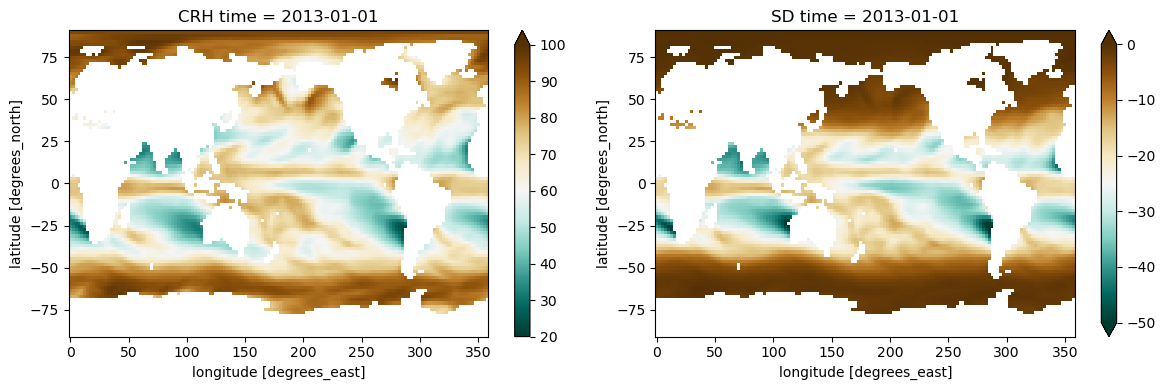

In [24]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
noland = dslmsk
CRH.where(noland.data==0).isel(time=0).plot(vmin=20, vmax=100, ax=axs[0],cmap='BrBG_r')
axs[0].set_title('CRH time = 2013-01-01')
SD.where(noland.data==0).isel(time=0).plot(vmin=-50, vmax=0, ax=axs[1],cmap='BrBG_r')
axs[1].set_title('SD time = 2013-01-01')
plt.tight_layout()
plt.savefig("CRH_SD.png")

## 4. Potential intensity:

In [25]:
# load in pyPI modules
from tcpyPI import pi
from tcpyPI.utilities import *

# define the sample data locations
def PI(ds, dim='p',CKCD=0.9):
    """ This function calculates PI over the given dataset using xarray """
    
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds[dim], ds['t'], ds['q'],
        kwargs=dict(CKCD=CKCD, ascent_flag=0, diss_flag=1.0, V_reduc=0.8, ptop=30, miss_handle=0),
        input_core_dims=[[], [], [dim, ], [dim, ], [dim, ],],
        output_core_dims=[[], [], [], [], []],
        vectorize=True   # Vectorize the operation for better performance
    )

    # store the result in an xarray data structure
    vmax, pmin, ifl, t0, otl = result
    vmax = vmax.fillna(0)
    
    out_ds=xr.Dataset({
        'vmax': vmax, 
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'otl': otl,
        })
    
    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

    # return the output from pi.py as an xarray data structure
    return out_ds  

def f_PI(ds_sst, ds_msl, ds_t, ds_q):
    # create new dataset that contains all the input variables
    # NOTE: ds_sst in unit of degC, ds_msl in unit of hPa, ds_t in unit of deg C and ds_q in unit of g/kg
    ds = xr.Dataset(
        data_vars=dict(
            sst = (['time','lat','lon'], sst.data), 
            msl = (['time','lat','lon'], msl.data), 
            t = (['time','p','lat','lon'], t.data), 
            q = (['time','p','lat','lon'], q.data), 
        ),
        coords=dict(
            p=("p", t.lev.data),
            lat=("lat", sst.lat.data),
            lon=("lon", sst.lon.data),
            time=("time", sst.time.data),
        )
    )
    
    ds_PI = PI(ds)
    return ds_PI

In [28]:
# Input data
sst = xr.open_dataset(f"{path}/TS.{forcing}.1950-2014.nc").TS.sel(time=slice('2013','2014'))  - 273.15 #K - T0 = degC
msl = xr.open_dataset(f"{path}/PSL.{forcing}.1950-2014.nc").PSL.sel(time=slice('2013','2014'))   / 100 #Pa /100 = hPa
t = xr.open_dataset(f"{path}/T.{forcing}.1950-2014.nc").T.sel(time=slice('2013','2014')).sortby('lev', ascending=False) - 273.15 #K - T0 = degC
q = xr.open_dataset(f"{path}/Q.{forcing}.1950-2014.nc").Q.sel(time=slice('2013','2014')).sortby('lev', ascending=False) * 1000 #kg/kg *1000=g/kg

mpi = f_PI(sst, msl, t, q)

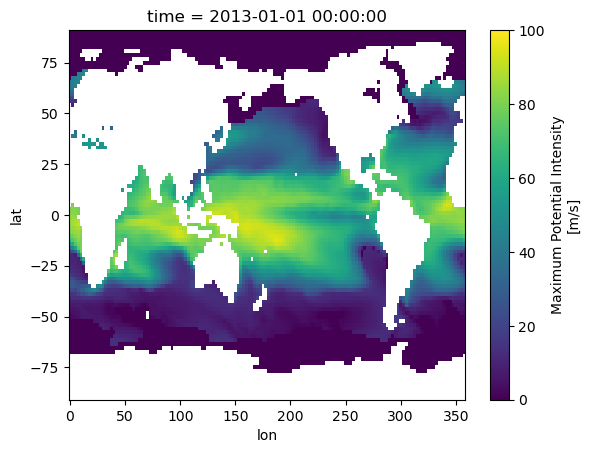

In [29]:
mpi.vmax.where(noland.data==0).isel(time=0).plot(vmin=0, vmax=100)
plt.savefig("PI")

## TCGI：

In [30]:
vort = abs((avort.avort*1e+05)).clip(min=None, max=3.7)
humi1 = CRH
humi2 = SD
ther = mpi.vmax
shea = vws.vws

# coeffients from Suzana (calculated from ERA5 data)
b1 = [-24.1323, 2.5120, 0.0770, 0.0622, -0.1202]  # with CRH
b2 = [-18.3563, 2.4829, 0.0735, 0.0798, -0.1346]  # with SD

area = np.log(np.cos(np.deg2rad(sst.lat.data))*2*2)
area_ext = np.tile(area, (len(sst.time.data), len(sst.lon.data), 1)).transpose(0,2,1)  # Rearrange dimensions to (time, lat, lon)
offset = xr.DataArray(area_ext, dims=['time', 'lat', 'lon'], 
                      coords={'time':sst.time, 'lon': sst.lon.data, 'lat': sst.lat.data})

# calculate two types of TCGI (namely mu1 & mu2)
coe = 'b1'
mu1 = np.exp(eval(coe)[0] + eval(coe)[1]*vort + eval(coe)[2]*humi1 + 
            eval(coe)[3]*ther + eval(coe)[4]*shea + offset)
coe = 'b2'
mu2 = np.exp(eval(coe)[0] + eval(coe)[1]*vort + eval(coe)[2]*humi2 + 
            eval(coe)[3]*ther + eval(coe)[4]*shea + offset)

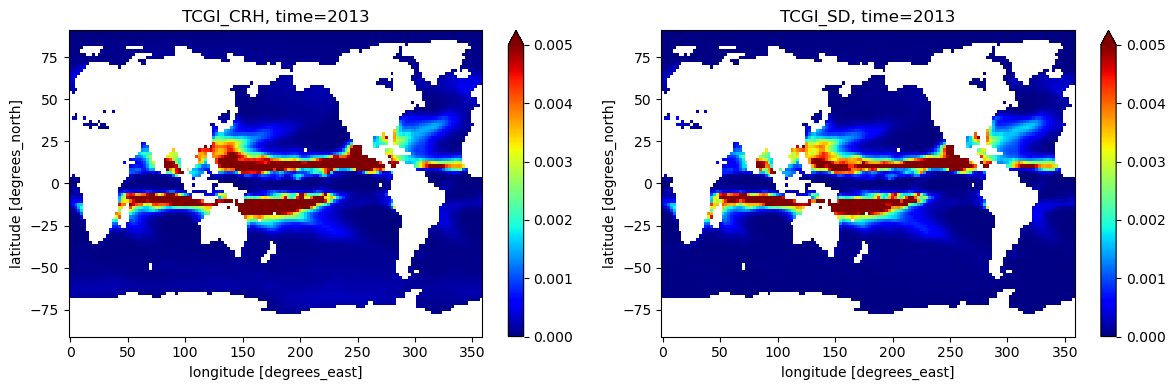

In [31]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
# Plot the  TCGI_CRH/
mu1.where(noland.data==0).mean('time').plot(vmin=0, vmax=0.005, ax=axs[0],cmap='jet')
axs[0].set_title(f'TCGI_CRH, time=2013')
mu2.where(noland.data==0).mean('time').plot(vmin=0, vmax=0.005, ax=axs[1],cmap='jet')
axs[1].set_title(f'TCGI_SD, time=2013')
plt.tight_layout()
plt.savefig(f"TCGI.png")

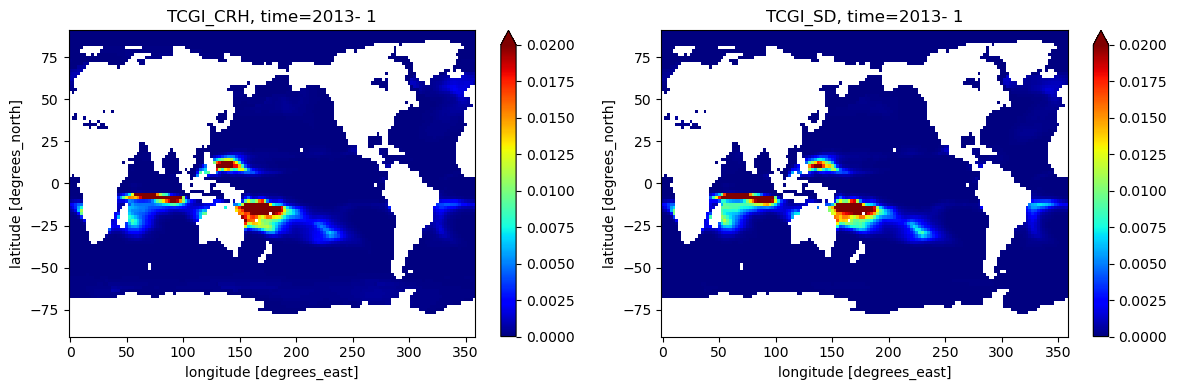

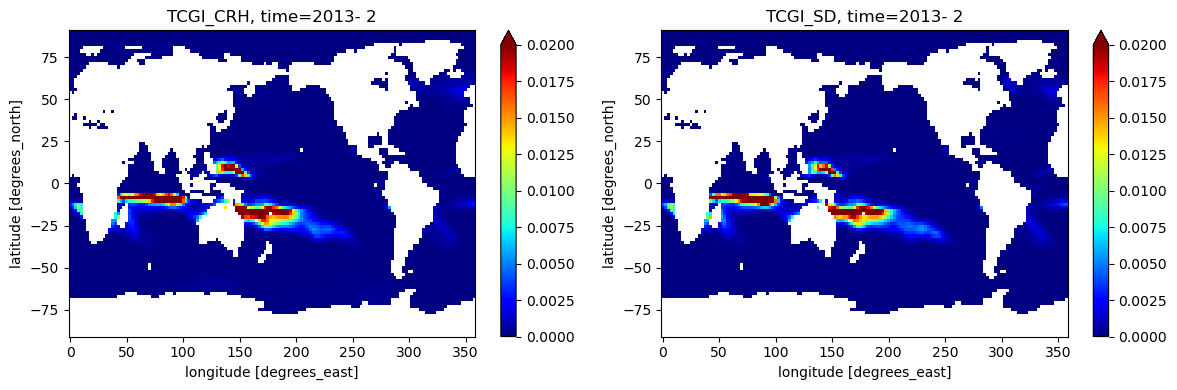

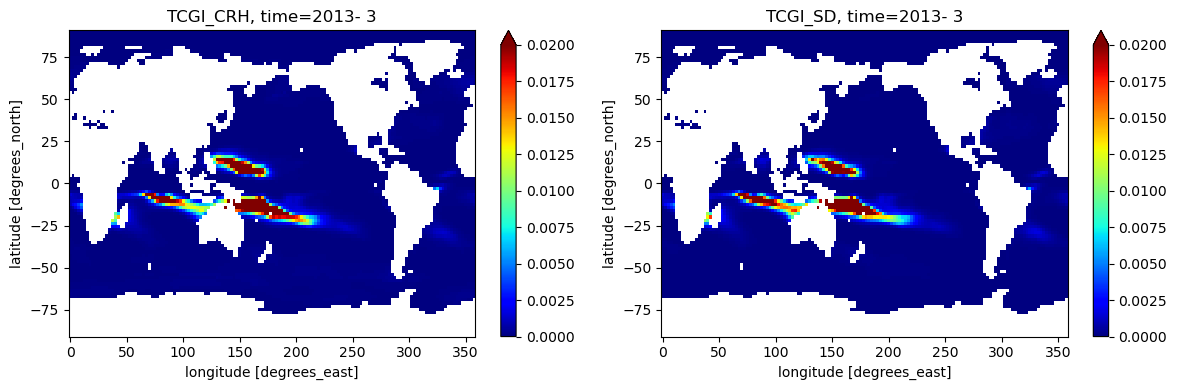

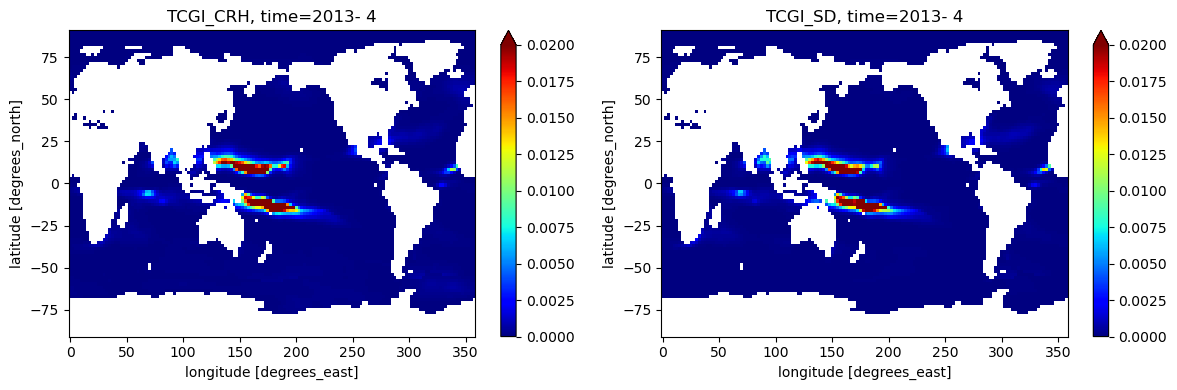

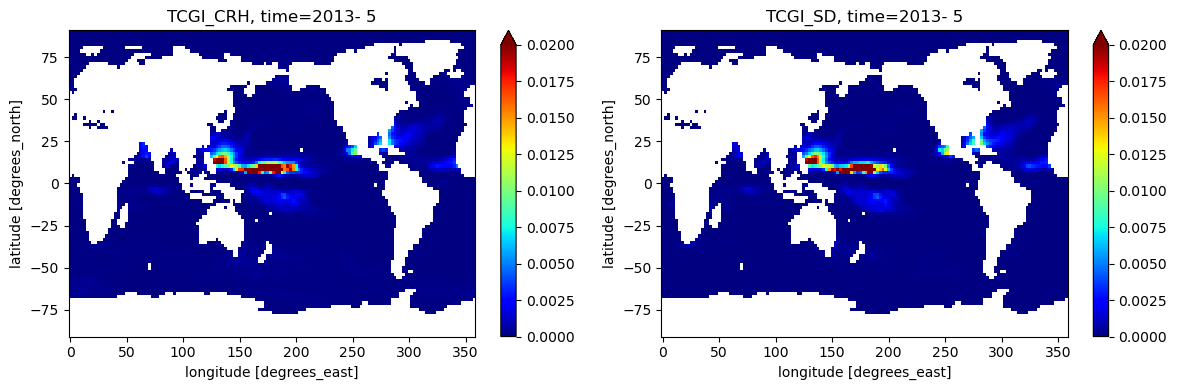

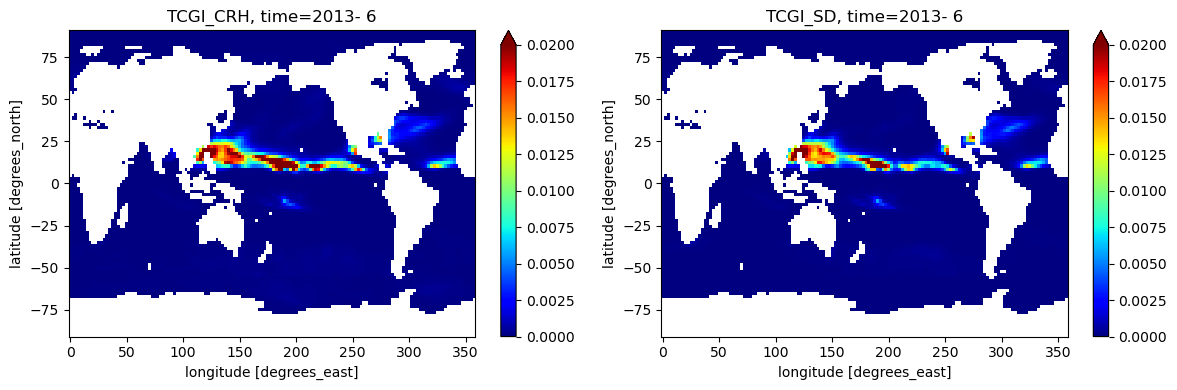

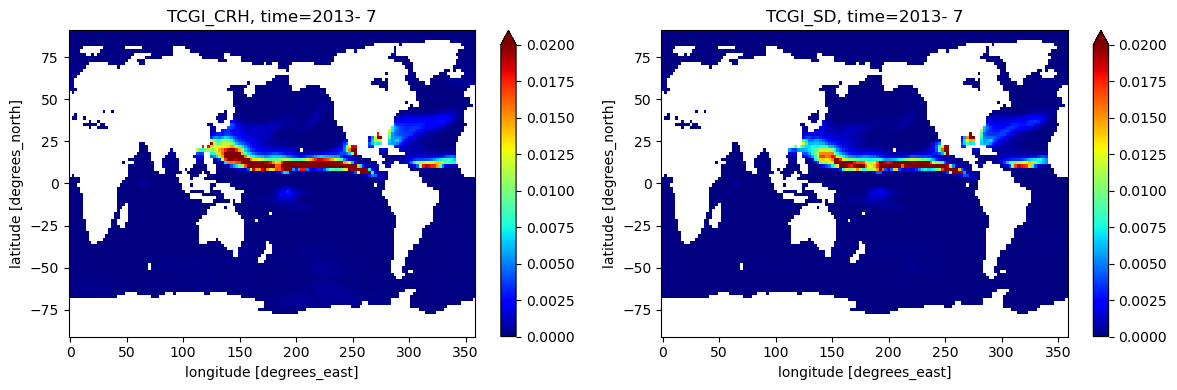

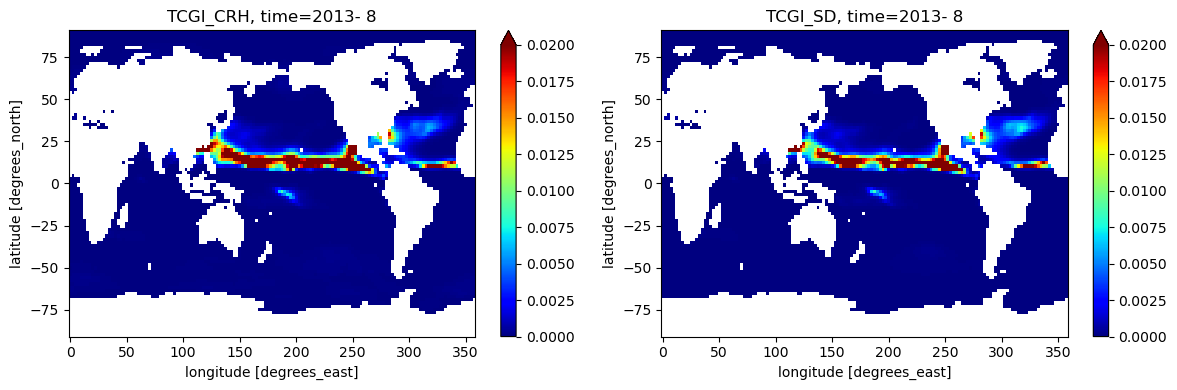

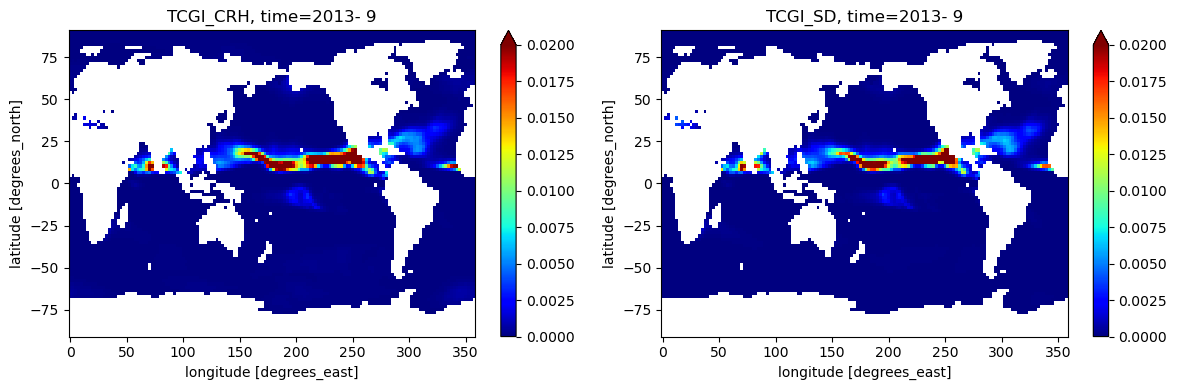

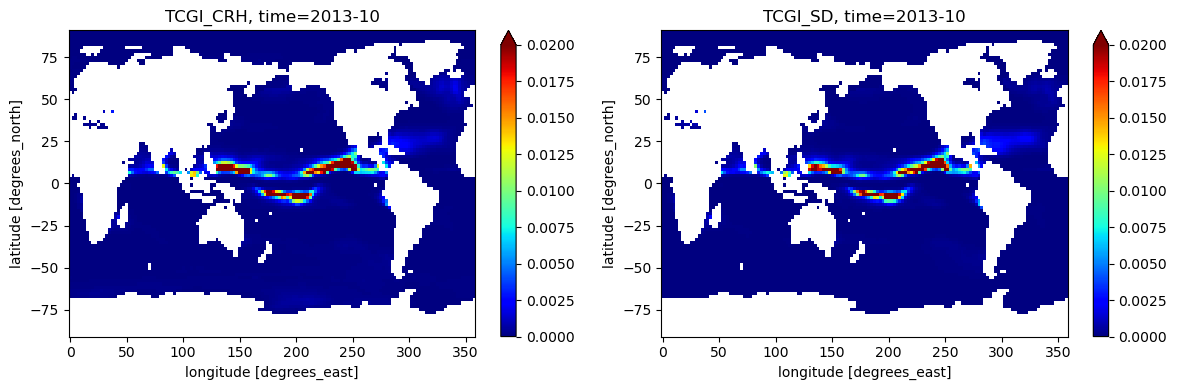

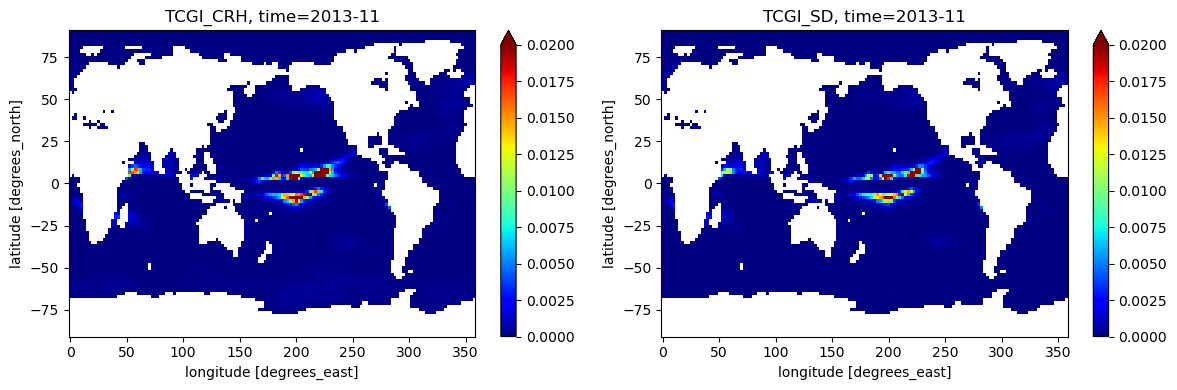

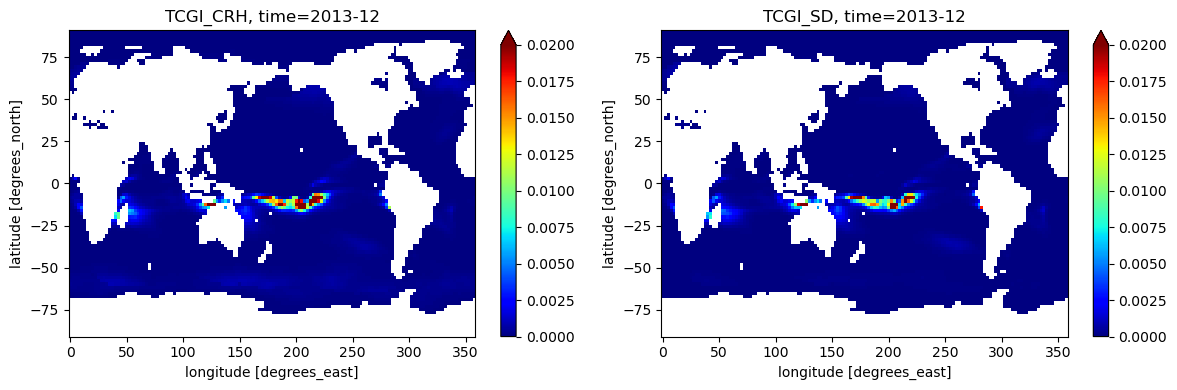

In [32]:
for i in range(1,13):
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    # Plot the  TCGI_CRH/
    mu1.where(noland.data==0).isel(time=i).plot(vmin=0, vmax=0.02, ax=axs[0],cmap='jet')
    axs[0].set_title(f'TCGI_CRH, time=2013-{i:2d}')
    mu2.where(noland.data==0).isel(time=i).plot(vmin=0, vmax=0.02, ax=axs[1],cmap='jet')
    axs[1].set_title(f'TCGI_SD, time=2013-{i:2d}')
    plt.tight_layout()
    plt.savefig(f"TCGI_{i}.png")